In [1]:
from google.colab import files

In [2]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!ls

kaggle.json  sample_data


In [4]:
!mkdir ~/.kaggle

In [5]:
!mv kaggle.json ~/.kaggle

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c store-sales-time-series-forecasting

 89% 19.0M/21.4M [00:02<00:00, 13.2MB/s]
100% 21.4M/21.4M [00:02<00:00, 8.37MB/s]


In [8]:
!ls

sample_data  store-sales-time-series-forecasting.zip


In [9]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [10]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40

Подключение всех необходимых библиотек

In [11]:
# Библиотека для работы с ОС
import os

# Стандартные библиотеки для работы с данными и визуализацией
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Подключение элементов библиотеки darts
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, StaticCovariatesTransformer
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.metrics import rmsle
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm.notebook import tqdm_notebook

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

Этап №1 - Обработка данных

In [12]:
# Функция для вывода информации (helper print)
def cprint(title, *args):
  print("=" * len(title), title, "=" * len(title), *args, sep="\n")

In [13]:
# Загрузка набора данных

PATH = "/content"

# Загрузка тренировочного набора данных
train = pd.read_csv(os.path.join(PATH, "train.csv"), parse_dates=["date"])
# Загрузка тестового набора данных
test = pd.read_csv(os.path.join(PATH, "test.csv"), parse_dates=["date"])

oil = pd.read_csv(os.path.join(PATH, "oil.csv"), parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv(os.path.join(PATH, "stores.csv"))
transaction = pd.read_csv(os.path.join(PATH, "transactions.csv"), parse_dates=["date"])
holiday = pd.read_csv(os.path.join(PATH, "holidays_events.csv"), parse_dates=["date"])

In [14]:
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [15]:
cprint(
    "Базовая информация о данных",
    f"Количество типов семейств                    : {num_family}",
    f"Количество магазинов                         : {num_store}",
    f"Количество пар магазин-семья                 : {num_family * num_store}",
    f"Количество целевых серий                     : {num_ts}",
    "",
    f"Количество уникальных дат в train            : {num_train_date}",
    f"Диапазон дат в train                         : {train_len} дней с {train_start} по {train_end}",
    f"Количество уникальных дат тестирования       : {num_test_date}",
    f"Диапазон дат тестирования                    : {test_len} дней с {test_start} по {test_end}",
)

Базовая информация о данных
Количество типов семейств                    : 33
Количество магазинов                         : 54
Количество пар магазин-семья                 : 1782
Количество целевых серий                     : 1782

Количество уникальных дат в train            : 1684
Диапазон дат в train                         : 1688 дней с 2013-01-01 по 2017-08-15
Количество уникальных дат тестирования       : 16
Диапазон дат тестирования                    : 16 дней с 2017-08-16 по 2017-08-31


In [16]:
# Определение разницы между диапазоном дат в train и уникальными значениями date в совокупности
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
# Преобразование данных к формату YYYY-MM-DD и помещение их в список
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()
unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [17]:
cprint(
    "Отсутствие пробелов во временных рядах",
    f"Список, включая количество уникальных точек данных: {unique_dp_count}",
    f"Пропущенные даты                                  : {missing_dates}",
)

Отсутствие пробелов во временных рядах
Список, включая количество уникальных точек данных: [1684]
Пропущенные даты                                  : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [18]:
# Переиндексация тренировочных данных
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# Заполняем отсутствующие значения нулём
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear") # линейная интерполяция в качестве заполнителя для 'id'

In [19]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [20]:
cprint(
    "Пропущенные даты торговли нефтью",
    f"Количество пропущенных дат торговли нефтью: {num_missing_oil_dates}",
    f"Количество выходных дней в пропусках      : {num_wknd_missing}",
    f"Общее число выходных дней                 : {total_num_wknd}",
)

Пропущенные даты торговли нефтью
Количество пропущенных дат торговли нефтью: 486
Количество выходных дней в пропусках      : 486
Общее число выходных дней                 : 486


In [21]:
# Переиндексация данных торговли нефтью
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# Заполнение пропущенных значений с помощью линейной интерполяции
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

In [22]:
num_zero_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(transaction.index)
missing_rec = total_rec - curr_rec - num_zero_sales

In [23]:
cprint(
    "Отсутствующие записи о транзакциях",
    f"Правильное количество записей   : {total_rec}",
    "",
    "Поломка...",
    f"Текущее количество записей      : {curr_rec}",
    f"Количество нулевых продаж       : {num_zero_sales}",
    f"Количество отсутствующих записей: {missing_rec}",
)

Отсутствующие записи о транзакциях
Правильное количество записей   : 91152

Поломка...
Текущее количество записей      : 83488
Количество нулевых продаж       : 7546
Количество отсутствующих записей: 118


In [24]:
# Рассчитаем общий объем продаж для каждого магазина
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# Переиндексация данных транзакции
transaction = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# Заполняем пропущенные значения нулями для дней с нулевыми продажами
transaction.loc[transaction.sales.eq(0), "transactions"] = 0.
transaction = transaction.drop(columns=["sales"])

# Заполняем оставшиеся пропущенные значения с помощью линейной интерполяции
transaction.transactions = transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [25]:
# Национальные праздники
national_locale_name = sorted(holiday[holiday.locale.eq("National")].locale_name.unique().tolist())
# Региональные праздники
regional_locale_name = sorted(holiday[holiday.locale.eq("Regional")].locale_name.unique().tolist())
# Локальные праздники
local_locale_name = sorted(holiday[holiday.locale.eq("Local")].locale_name.unique().tolist())

In [26]:
cprint(
    "Список местных названий для каждого праздника",
    "Местные названия национальных праздников:",
    national_locale_name,
    "",
    "Местные названия региональных праздников:",
    regional_locale_name,
    "",
    "Местные названия локальных праздников   :",
    local_locale_name,
)

Список местных названий для каждого праздника
Местные названия национальных праздников:
['Ecuador']

Местные названия региональных праздников:
['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']

Местные названия локальных праздников   :
['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


In [27]:
holiday[(holiday.description.str.contains("Navidad"))&(holiday.date.dt.year.eq(2012))]

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False


In [28]:
# Обработка столбца данных holiday
def process_holiday(s):
    # Если строка равна "futbol", то вернём строку futbol
    if "futbol" in s:
        return "futbol"

    # Иначе определим список городов и штатов (объединение)
    to_remove = list(set(store.city.str.lower()) | set(store.state.str.lower()))

    for w in to_remove:
        # Заменяем все значения во входной строке с значения, хранящегося в строке w, на пустую строку
        s = s.replace(w, "")
    return s

In [29]:
# Обработка столбца description в наборе данных holiday
holiday.description = holiday.apply(
    # Определение лямбда-функции, которая заменяет встречное local_name на пустую строку
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""),
    # Учитываем столбцы
    axis=1,
).apply(
    # Встраиваем свою функцию в очередь функций apply
    process_holiday
).replace(
    # Заменяем все строки, соответствующие регулярному выражению, на пустую строку
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    # Заменяем все строки, соответствующие регулярному выражению, на пустую строку
    r"\s+|-", " ", regex=True,
).str.strip() # Приводим всё к строке с удалением пробелов вначале и вконце

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


In [30]:
holiday[31:39]

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,navidad,False
32,2012-12-22,Holiday,Local,Salinas,cantonizacion,False
33,2012-12-22,Additional,National,Ecuador,navidad,False
34,2012-12-23,Additional,National,Ecuador,navidad,False
35,2012-12-24,Bridge,National,Ecuador,navidad,False
36,2012-12-24,Additional,National,Ecuador,navidad,False
37,2012-12-25,Holiday,National,Ecuador,navidad,False
38,2012-12-26,Additional,National,Ecuador,navidad,False


In [31]:
# Удаление всех перенесённых праздничных дней
holiday = holiday[holiday.transferred.eq(False)]

In [32]:
#########################################
### Субботы, объявленные рабочими днями ###
#########################################
work_days = holiday[holiday.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)

# Удаление праздничных дней, в которых тип не равен Work Day (объявлен не рабочим днём)
holiday = holiday[holiday.type!="Work Day"].reset_index(drop=True)

###################################
### Локальные праздники (уровень города) ###
###################################
local_holidays = holiday[holiday.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### Региональные праздники (уровень штата) ###
#######################################
regional_holidays = holiday[holiday.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### Национальные праздники ###
#########################
national_holidays = holiday[holiday.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")

# Разные национальные праздники могут приходиться на один и тот же день
national_holidays = national_holidays.groupby("date").sum().reset_index()

# Сокращение названий для удобства визуализации
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [33]:
sales_ts = pd.pivot_table(train, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transaction, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(train, values="onpromotion", index="date", columns=["store_nbr", "family"])

sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

In [34]:
# Масштабируемая целевая серия
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# Обратное преобразование в длинную форму и добавление столбцов с праздниками
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,
).reset_index().merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# Включаем фиктивную переменную для дат без каких-либо праздников
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,0.105263,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-01-03,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013-01-04,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2013-01-05,1,AUTOMOTIVE,0.263158,Quito,Pichincha,D,13,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Даты с нулевыми продажами
Даты с нулевыми продажами                : ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']
Соответствующие показатели нулевых продаж: [1765, 1732, 1759, 1753, 1754]
Общее количество целевых серий           : 1782


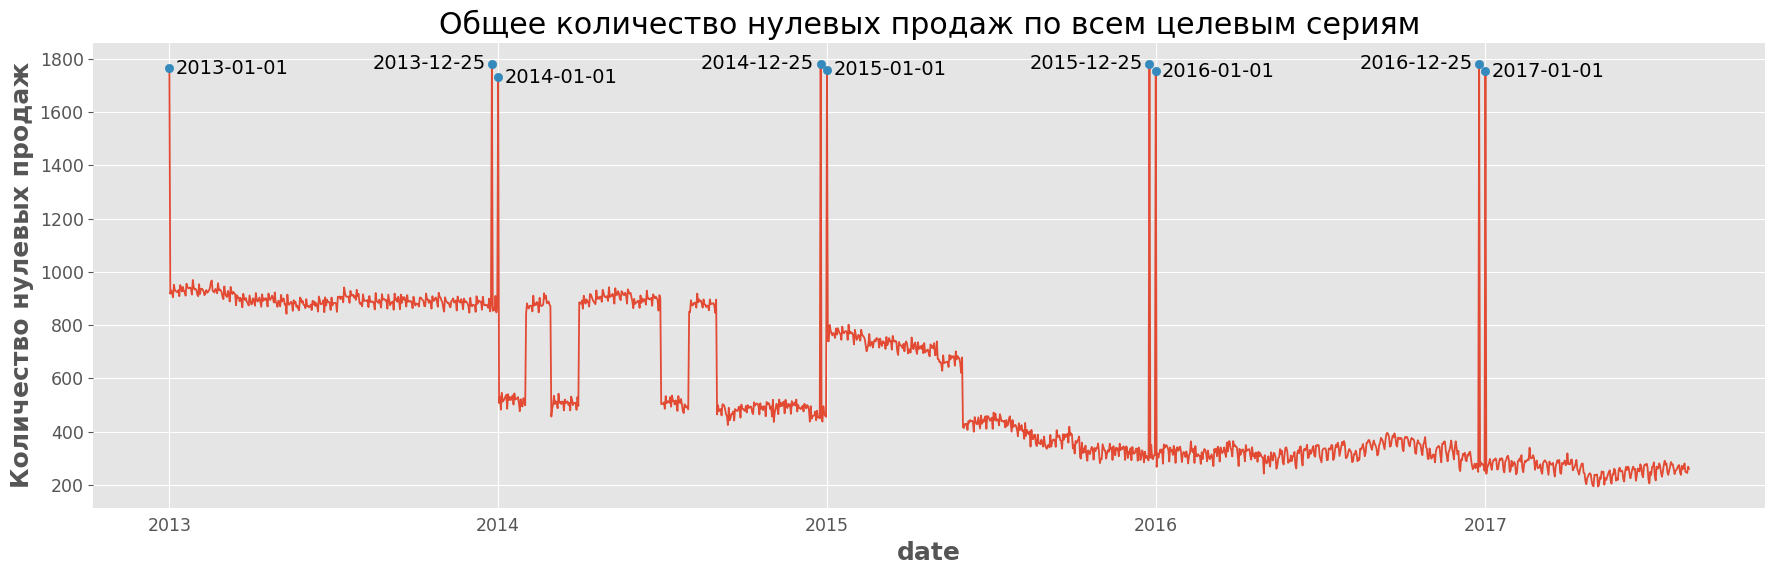

In [35]:
# Вывод графика количества нулевых записей
def plot_zero_count_ts():
    zero_count_ts = (sales_ts.eq(0)).sum(axis=1).to_frame("zero_sales_ct").reset_index()
    zero_count_filtered = zero_count_ts[zero_count_ts.zero_sales_ct.gt(1500)].reset_index(drop=True)
    high_zero_dates = zero_count_filtered.date.dt.strftime("%Y-%m-%d")
    high_zero_dates = [d for d in high_zero_dates if not d.endswith("12-25")]
    high_zero_counts = zero_count_filtered[zero_count_filtered.date.isin(high_zero_dates)].zero_sales_ct.tolist()

    cprint(
        "Даты с нулевыми продажами",
        f"Даты с нулевыми продажами                : {high_zero_dates}",
        f"Соответствующие показатели нулевых продаж: {high_zero_counts}",
        f"Общее количество целевых серий           : {num_ts}",
    )

    plt.figure(figsize=(18, 6))

    sns.lineplot(data=zero_count_ts, x="date", y="zero_sales_ct")
    sns.scatterplot(
        data=zero_count_filtered, x="date", y="zero_sales_ct",
        color=COLORS[1],
        edgecolor=COLORS[1],
        zorder=2,
    )

    for j in range(len(zero_count_filtered.index)):
        ha = "left" if j%2==0 else "right"
        offset = pd.Timedelta(7, "d") if ha=="left" else pd.Timedelta(-7, "d")
        plt.text(
            x=zero_count_filtered.date[j]+offset, y=zero_count_filtered.zero_sales_ct[j],
            s=zero_count_filtered.date[j].strftime("%Y-%m-%d"),
            ha=ha,
            va="center",
            size=14,
        )
    plt.ylabel("Количество нулевых продаж")
    plt.title("Общее количество нулевых продаж по всем целевым сериям")
    plt.tight_layout()
    plt.show()

# Вывод графиков
plot_zero_count_ts()

Постоянная целевая серия
Количество постоянных целевых серий  : 53
Список уникальных постоянных значений: [0.0]


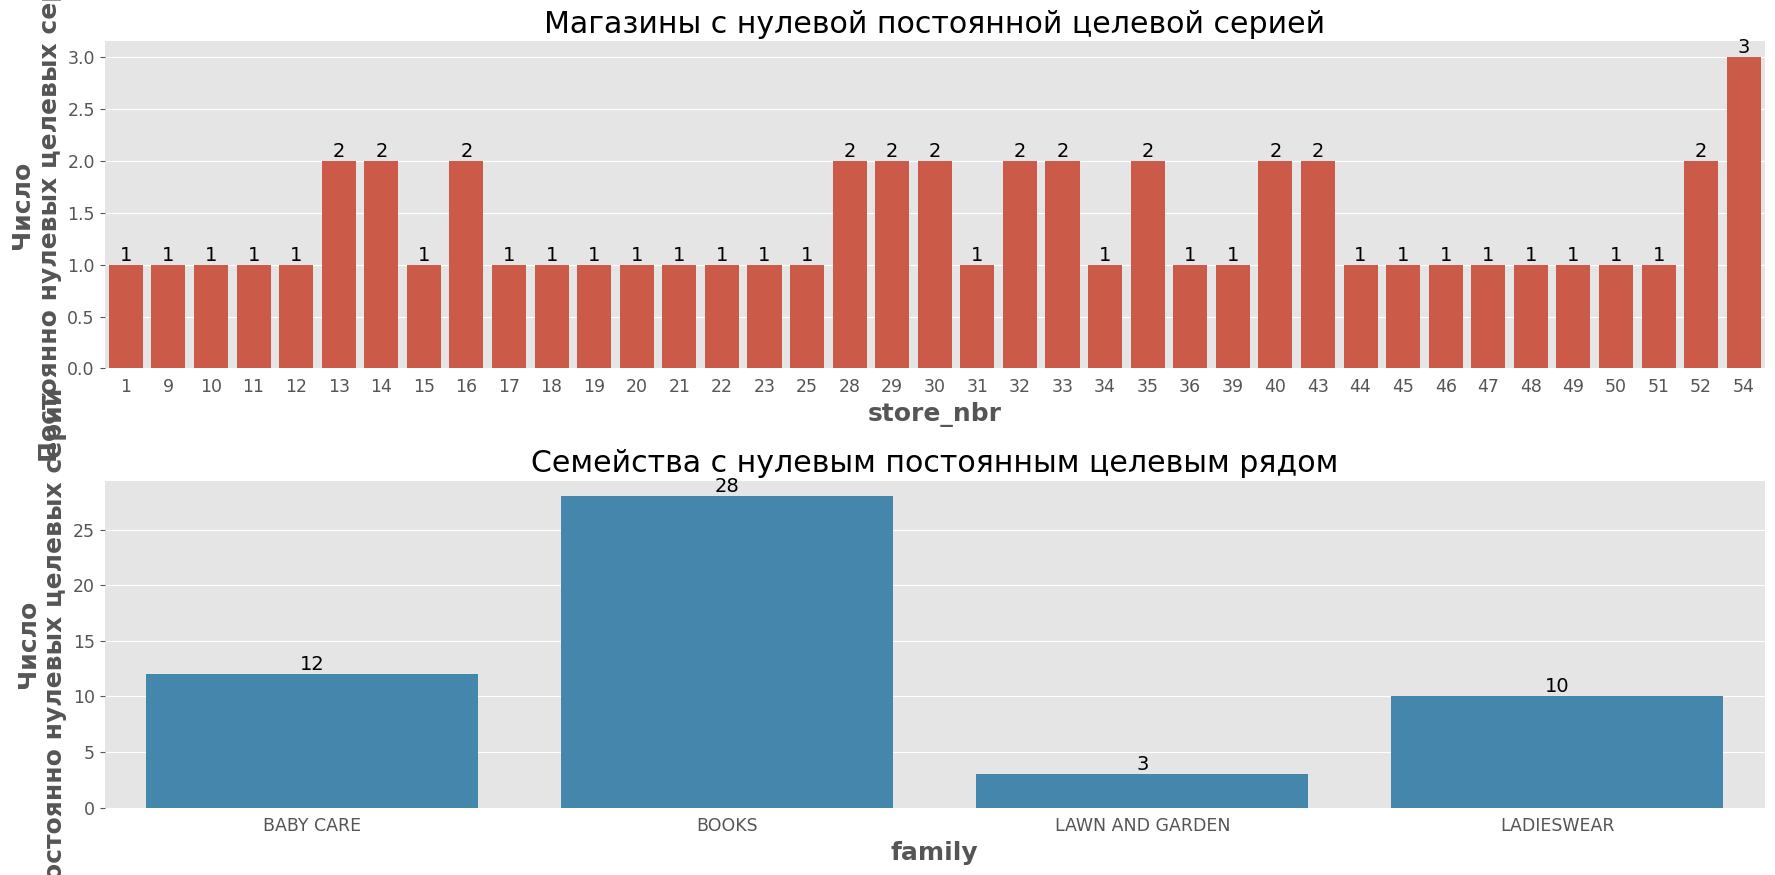

In [36]:
# Вывод информации о целевых сериях
def plot_constant_ts_distribution():
    const_ts = sales_ts.iloc[:, (sales_ts.std()==0).tolist()]
    const_ts_labels = const_ts.columns.to_frame().reset_index(drop=True)

    cprint(
        "Постоянная целевая серия",
        f"Количество постоянных целевых серий  : {len(const_ts.columns)}",
        f"Список уникальных постоянных значений: {const_ts.iloc[0].unique().tolist()}",
    )

    fig = plt.figure(figsize=(18, 9))

    ax0 = sns.countplot(
        data=const_ts_labels, x="store_nbr",
        color=COLORS[0],
        ax=fig.add_subplot(211),
    )
    ax0.bar_label(ax0.containers[0], size=14)
    plt.ylabel("Число\nПостоянно нулевых целевых серий")
    plt.title("Магазины с нулевой постоянной целевой серией")

    ax1 = sns.countplot(
        data=const_ts_labels, x="family",
        color=COLORS[1],
        ax=fig.add_subplot(212),
    )
    ax1.bar_label(ax1.containers[0], size=14)
    plt.ylabel("Число\nПостоянно нулевых целевых серий")
    plt.title("Семейства с нулевым постоянным целевым рядом")

    plt.tight_layout()
    plt.show()

plot_constant_ts_distribution()

Временные ряды с начальными нулями (исключая целевые ряды с нулевой константой)
Общее количество временных рядов                : 1729
Количество временных рядов с > 1 начальным нулем: 865


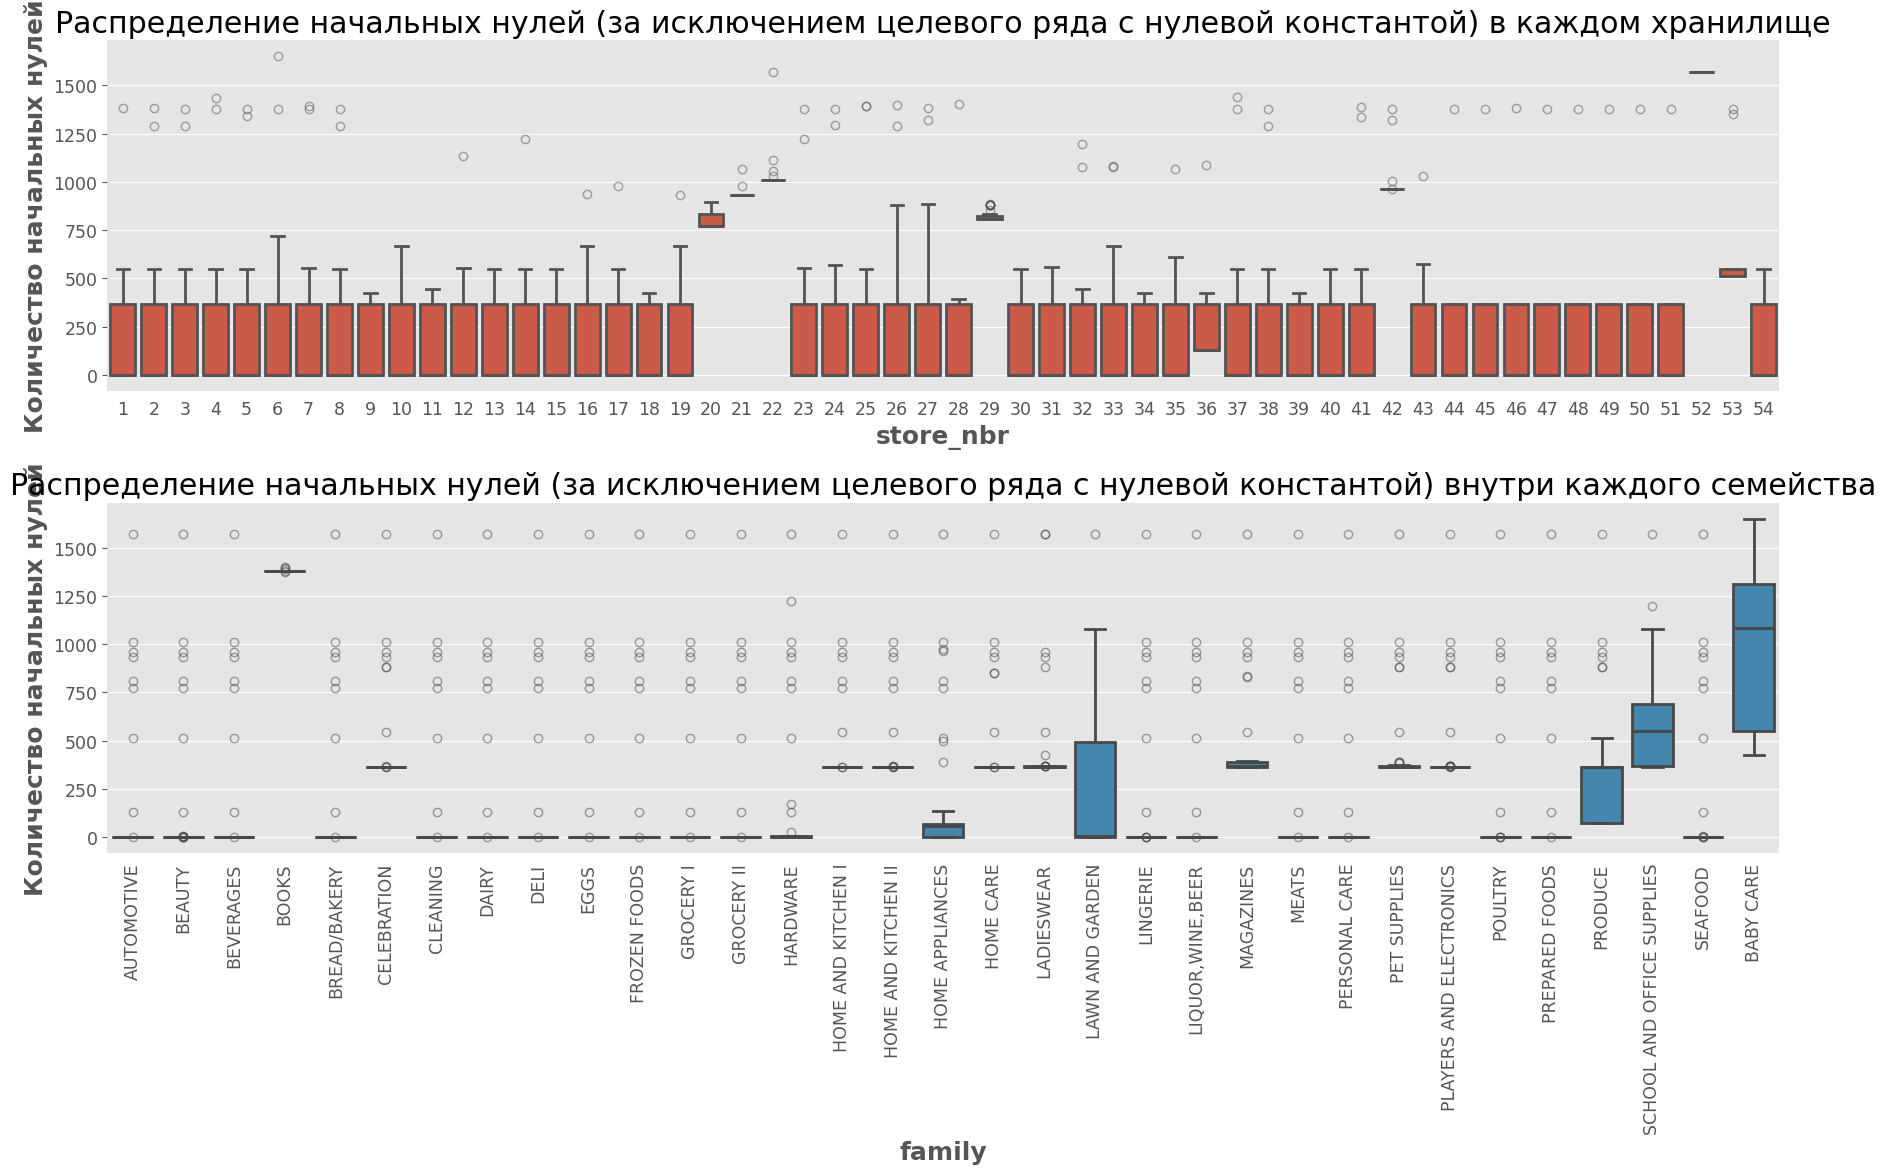

In [37]:
# Подсчёт начальных нулей
def count_leading_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return nonzero_idx[0]
    else:
        return len(x)

# Построение графика распределения начальных нулей
def plot_leading_zeros_distribution():
    leading_zeros = sales_ts.apply(count_leading_zeros).to_frame("num_leading_zeros").reset_index()
    leading_zeros = leading_zeros[leading_zeros.num_leading_zeros.lt(train_len)]

    cprint(
        "Временные ряды с начальными нулями (исключая целевые ряды с нулевой константой)",
        f"Общее количество временных рядов                : {len(leading_zeros.index)}",
        f"Количество временных рядов с > 1 начальным нулем: {leading_zeros.num_leading_zeros.gt(1).sum()}",
    )

    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }

    fig = plt.figure(figsize=(18, 12))

    ax0 = sns.boxplot(
        data=leading_zeros, x="store_nbr", y="num_leading_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Количество начальных нулей")
    plt.title("Распределение начальных нулей (за исключением целевого ряда с нулевой константой) в каждом хранилище")

    ax1 = sns.boxplot(
        data=leading_zeros, x="family", y="num_leading_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Количество начальных нулей")
    plt.title("Распределение начальных нулей (за исключением целевого ряда с нулевой константой) внутри каждого семейства")

    plt.tight_layout()
    plt.show()

plot_leading_zeros_distribution()

Целевая серия с конечными нулями (исключая целевую серию с нулевой константой)
Общее количество временных рядов           : 1729
Количество целевых серий с конечными нулями: 208


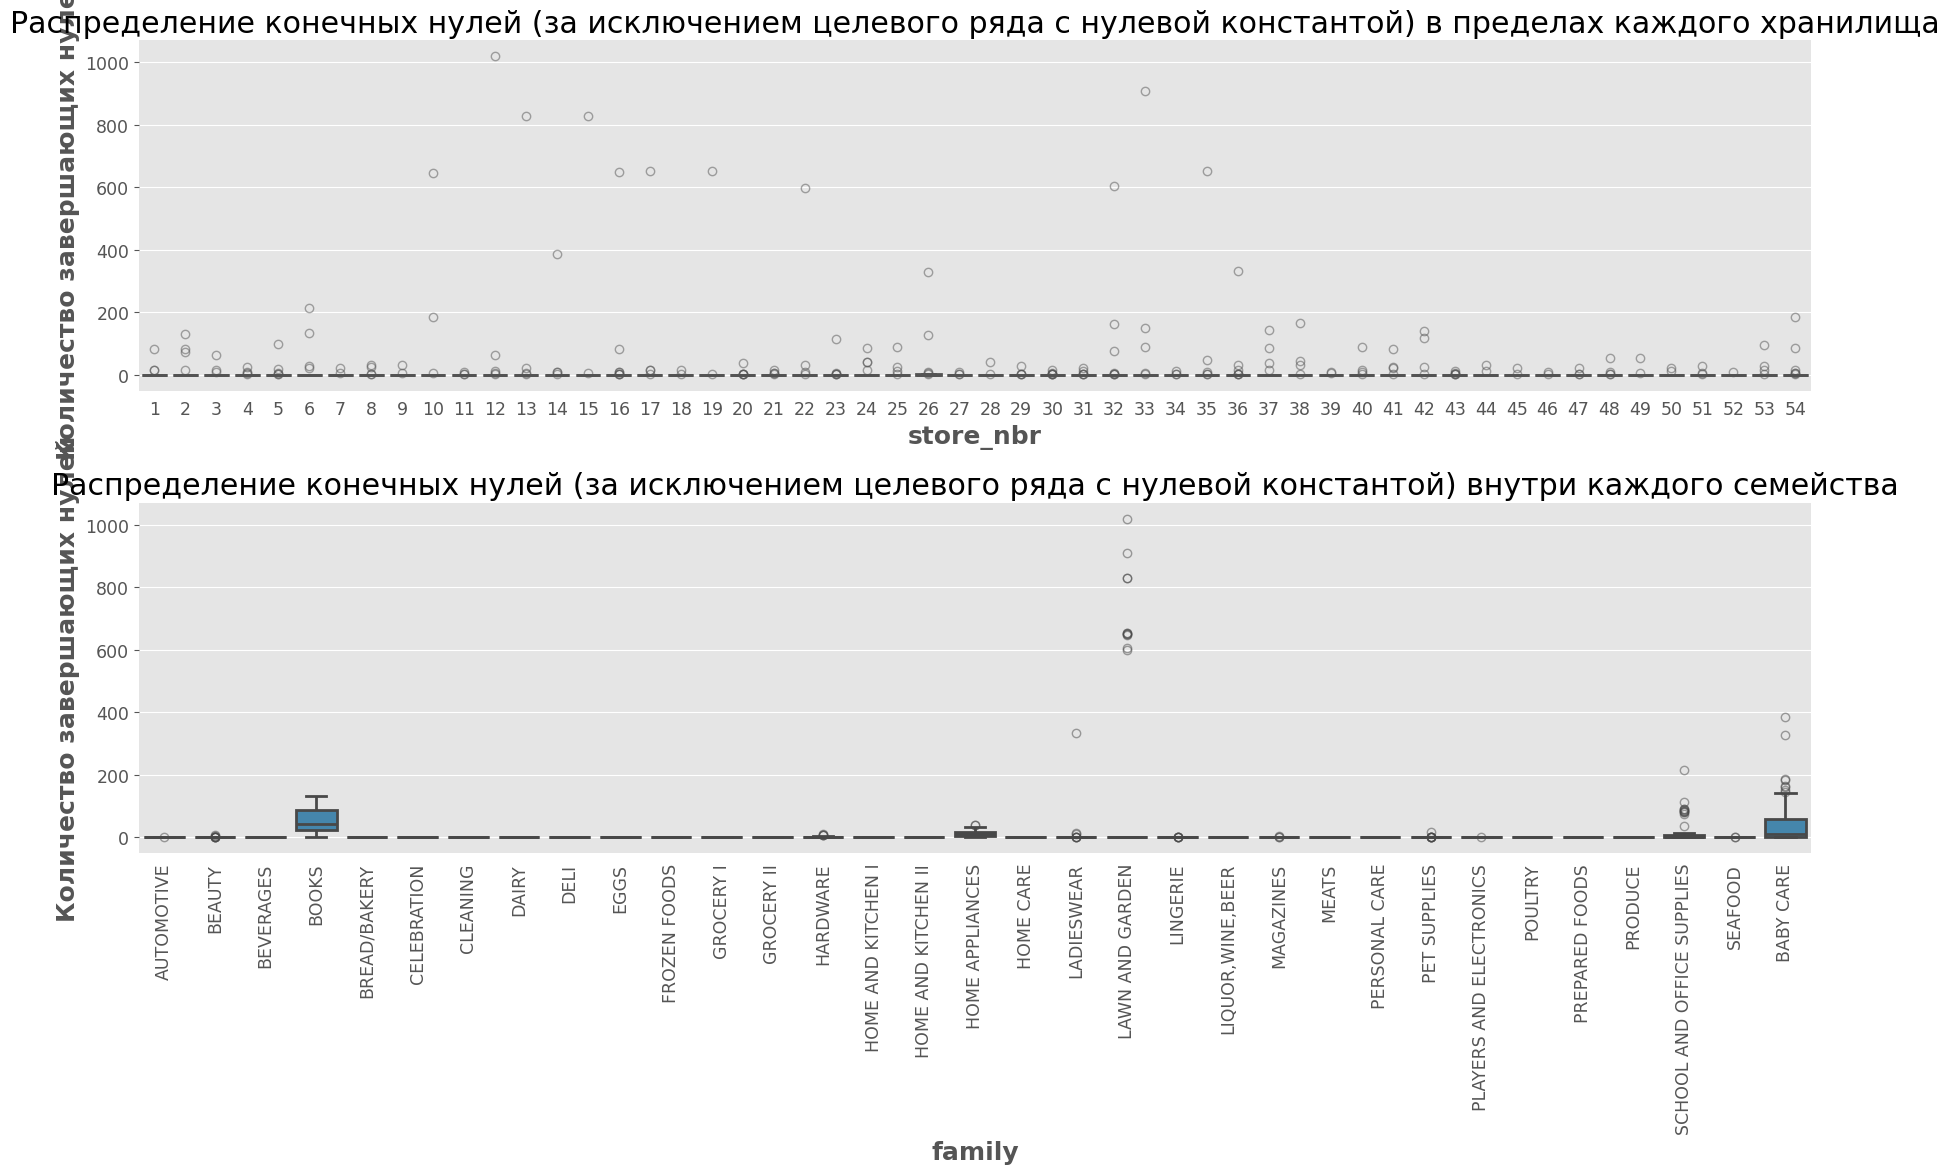

In [38]:
# Подсчёт конечных нулей
def count_trailing_zeros(x):
    nonzero_idx = np.where(x!=0)[0]
    if len(nonzero_idx) > 0:
        return len(x) - nonzero_idx[-1] - 1
    else:
        return len(x)

# Построение графика распределения конечных нулей
def plot_trailing_zeros_distribution():
    trailing_zeros = sales_ts.apply(count_trailing_zeros).to_frame("num_trailing_zeros").reset_index()
    trailing_zeros = trailing_zeros[trailing_zeros.num_trailing_zeros.lt(train_len)]

    cprint(
        "Целевая серия с конечными нулями (исключая целевую серию с нулевой константой)",
        f"Общее количество временных рядов           : {len(trailing_zeros.index)}",
        f"Количество целевых серий с конечными нулями: {trailing_zeros.num_trailing_zeros.gt(0).sum()}",
    )

    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.5},
    }

    fig = plt.figure(figsize=(18, 12))

    ax0 = sns.boxplot(
        data=trailing_zeros, x="store_nbr", y="num_trailing_zeros",
        color=COLORS[0],
        ax=fig.add_subplot(211),
        **plot_kwargs,
    )
    plt.ylabel("Количество завершающих нулей")
    plt.title("Распределение конечных нулей (за исключением целевого ряда с нулевой константой) в пределах каждого хранилища")

    ax1 = sns.boxplot(
        data=trailing_zeros, x="family", y="num_trailing_zeros",
        color=COLORS[1],
        ax=fig.add_subplot(212),
        **plot_kwargs,
    )
    plt.xticks(rotation=90)
    plt.ylabel("Количество завершающих нулей")
    plt.title("Распределение конечных нулей (за исключением целевого ряда с нулевой константой) внутри каждого семейства")

    plt.tight_layout()
    plt.show()

plot_trailing_zeros_distribution()

Коварианты        : oil, onpromotion, transactions
Прошлые ковариации: transactions
Будущие коварианты: oil, onpromotion


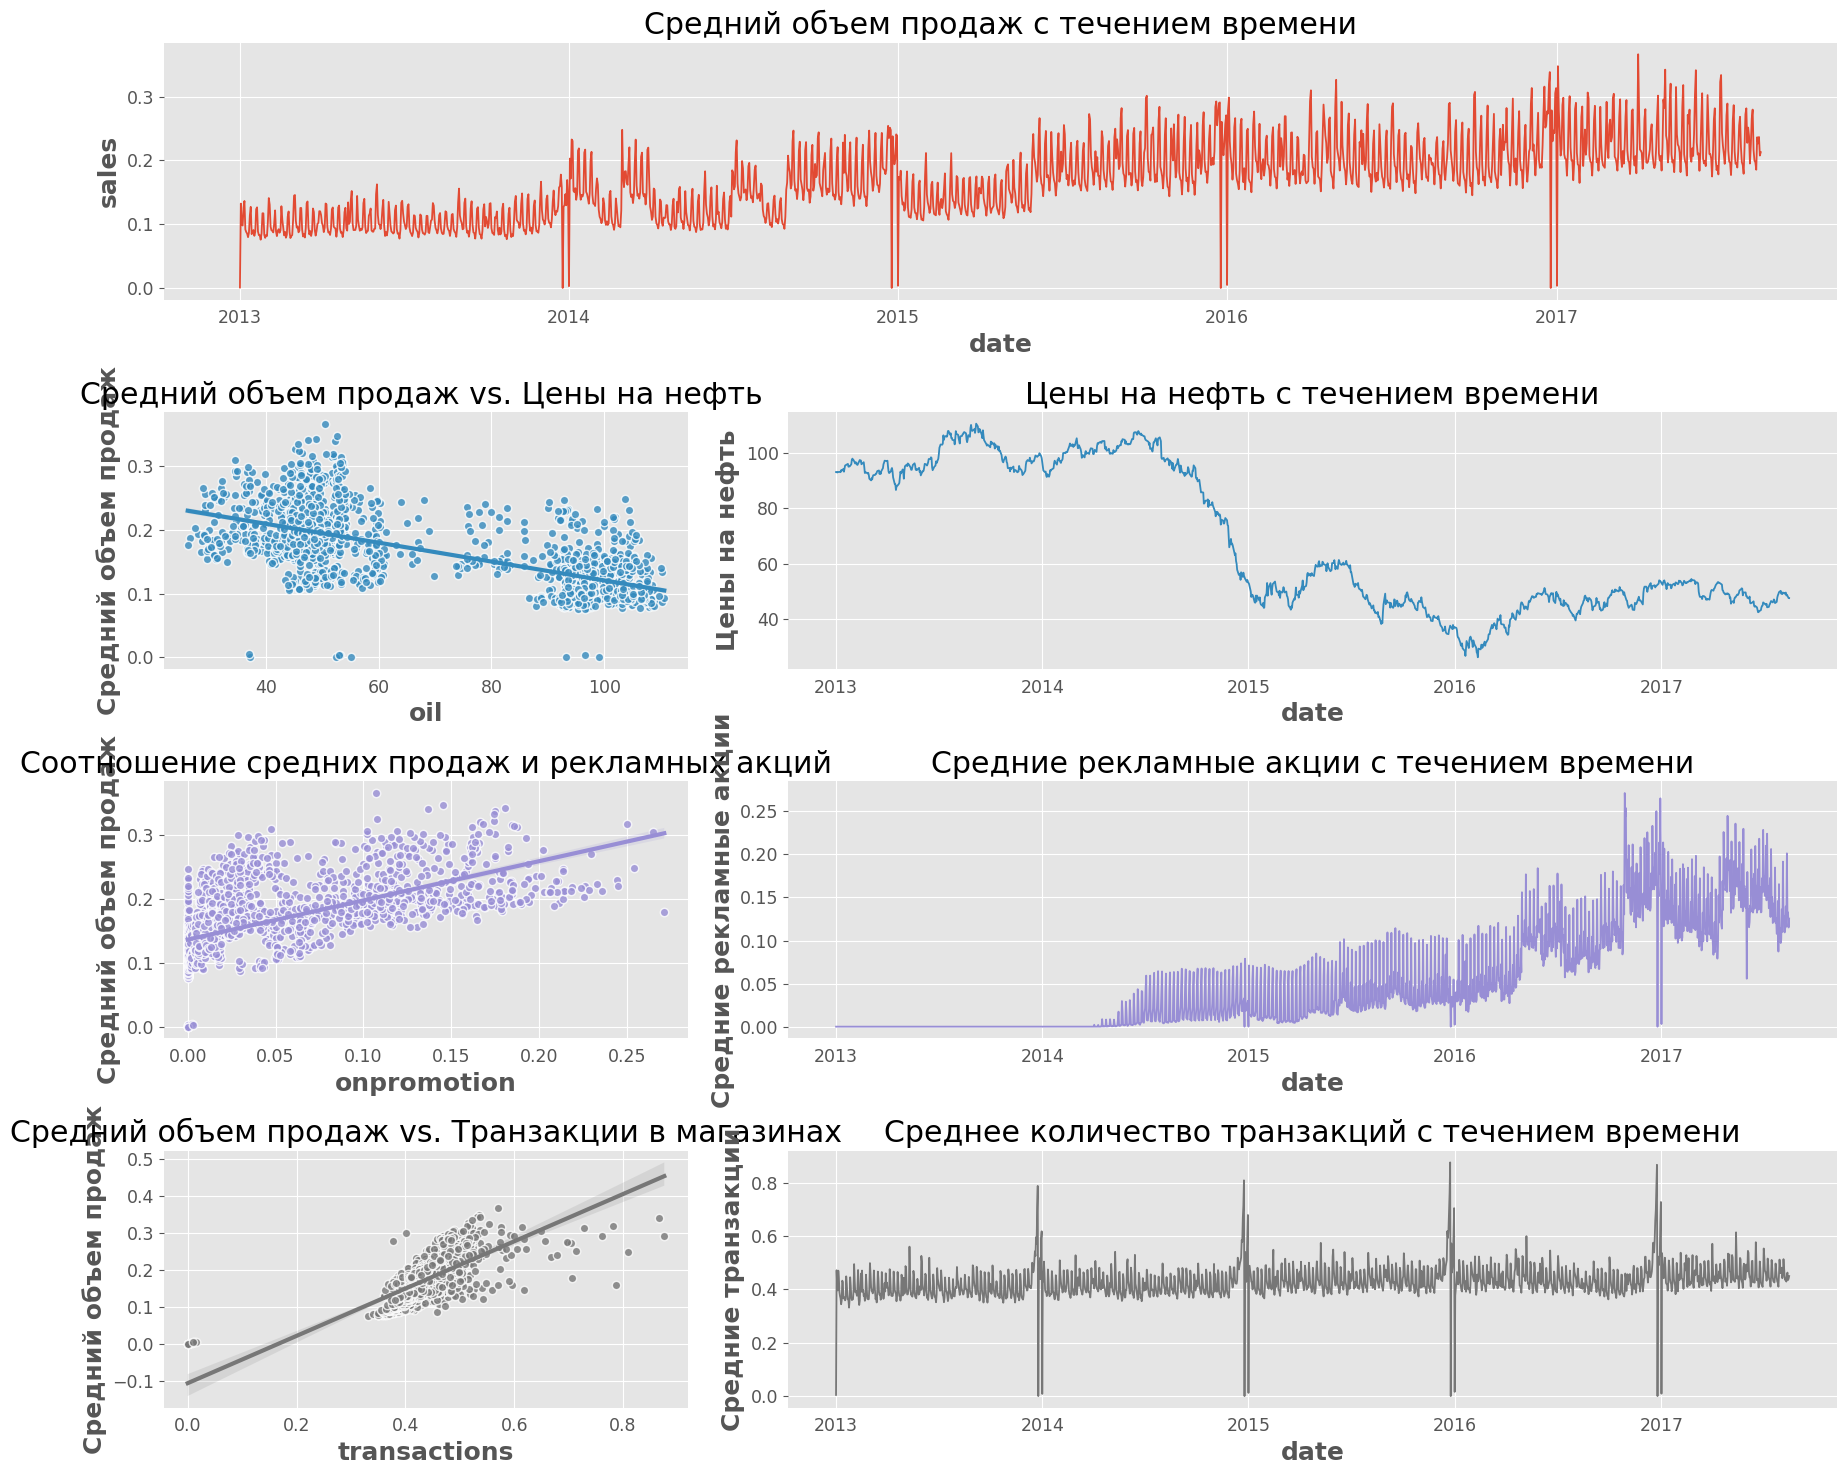

In [39]:
# График корреляции продаж
def plot_sales_correlation():
    tr_ts_scaled = tr_ts.copy()
    tr_ts_scaled[tr_ts_scaled.columns] = scaler.fit_transform(tr_ts_scaled)

    promo_ts_scaled = promo_ts.copy()
    promo_ts_scaled[promo_ts_scaled.columns] = scaler.fit_transform(promo_ts_scaled)

    mean_sales_ts_scaled = sales_ts_scaled.mean(axis=1).to_frame("sales").reset_index()
    mean_promo_ts_scaled = promo_ts_scaled.mean(axis=1).to_frame("onpromotion").reset_index()
    mean_tr_ts_scaled = tr_ts_scaled.mean(axis=1).to_frame("transactions").reset_index()

    cprint(
        "Коварианты        : oil, onpromotion, transactions",
        "Прошлые ковариации: transactions",
        "Будущие коварианты: oil, onpromotion",
    )

    plot_kwargs = {
        "scatter_kws": {"edgecolor": "white"},
        "line_kws": {"lw": 3},
    }

    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(4, 2, width_ratios=(1, 2))

    sns.lineplot(
        data=mean_sales_ts_scaled,
        x="date",
        y="sales",
        ax=fig.add_subplot(gs[0, :]),
    )
    plt.title("Средний объем продаж с течением времени")

    sns.regplot(
        x=oil.oil.iloc[:train_len], y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[1, 0]),
        color=COLORS[1],
        **plot_kwargs,
    )

    plt.ylabel("Средний объем продаж")
    plt.title("Средний объем продаж vs. Цены на нефть ")

    sns.lineplot(
        data=oil.iloc[:train_len, :], x="date", y="oil",
        ax=fig.add_subplot(gs[1, 1]),
        color=COLORS[1],
    )
    plt.ylabel("Цены на нефть")
    plt.title("Цены на нефть с течением времени")

    sns.regplot(
        x=mean_promo_ts_scaled.onpromotion, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[2, 0]),
        color=COLORS[2],
        **plot_kwargs,
    )
    plt.xlabel("onpromotion")
    plt.ylabel("Средний объем продаж")
    plt.title("Соотношение средних продаж и рекламных акций")

    sns.lineplot(
        data=mean_promo_ts_scaled, x="date", y="onpromotion",
        ax=fig.add_subplot(gs[2, 1]),
        color=COLORS[2],
    )
    plt.ylabel("Средние рекламные акции")
    plt.title("Средние рекламные акции с течением времени")

    sns.regplot(
        x=mean_tr_ts_scaled.transactions, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[3, 0]),
        color=COLORS[3],
        **plot_kwargs,
    )
    plt.xlabel("transactions")
    plt.ylabel("Средний объем продаж")
    plt.title("Средний объем продаж vs. Транзакции в магазинах")

    sns.lineplot(
        data=mean_tr_ts_scaled, x="date", y="transactions",
        ax=fig.add_subplot(gs[3, 1]),
        color=COLORS[3],
    )
    plt.ylabel("Средние транзакции")
    plt.title("Среднее количество транзакций с течением времени")

    plt.tight_layout()
    plt.show()

plot_sales_correlation()

Статические коварианты                                                 : city, state
Количество уникальных городов                                          : 22
Количество уникальных штатов                                           : 16
Количество штатов, в которых магазины расположены только в одном городе: 12


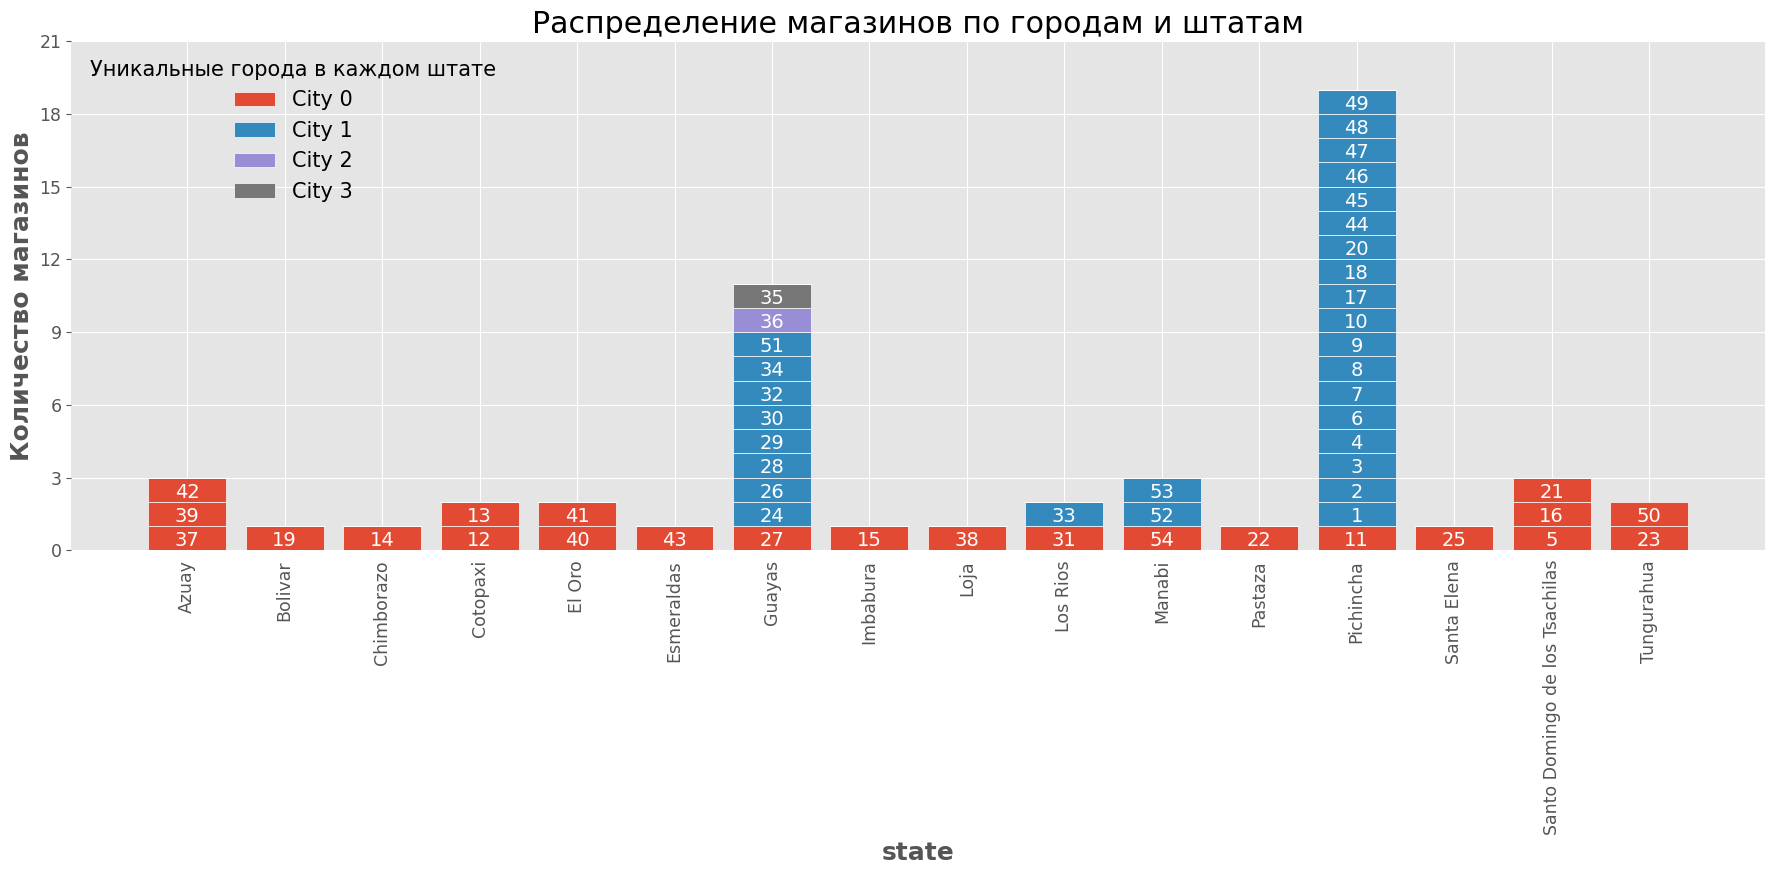

In [40]:
# Распределение городов и штатов
def plot_city_state_distribution(store):
    cprint(
        "Статические коварианты                                                 : city, state",
        f"Количество уникальных городов                                          : {store.city.nunique()}",
        f"Количество уникальных штатов                                           : {store.state.nunique()}",
        f"Количество штатов, в которых магазины расположены только в одном городе: {(store.groupby('state').city.nunique().eq(1)).sum()}",
    )

    store = store.copy().sort_values(["state", "city", "store_nbr"])
    state_list = store.state.unique()
    bar_bottom = np.zeros(len(state_list))
    counter = {}

    fig = plt.figure(figsize=(18, 9))

    for num in store.store_nbr.unique():
        curr_state, curr_city = store.loc[store.store_nbr.eq(num), ["state", "city"]].values[0]
        if curr_state not in counter:
            counter[curr_state] = []
        if curr_city not in counter[curr_state]:
            counter[curr_state].append(curr_city)
        state_ind = (state_list==curr_state).astype(int)
        plt.bar(
            x=state_list, height=state_ind,
            bottom=bar_bottom,
            color=COLORS[len(counter[curr_state])-1],
            edgecolor="white",
            label=f"City {len(counter[curr_state])-1}",
        )
        bar_bottom += state_ind
        running_total = bar_bottom[np.argmax(state_ind)]
        plt.text(
            x=curr_state, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Уникальные города в каждом штате")
    plt.xticks(rotation=90)
    plt.yticks(list(range(0, 22, 3)))
    plt.xlabel("state")
    plt.ylabel("Количество магазинов")
    plt.title("Распределение магазинов по городам и штатам")

    plt.tight_layout()
    plt.show()

plot_city_state_distribution(store)

In [41]:
# Сохраняем некоторые национальные праздники, которые оказывают большее влияние на продажи
selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

# Комбинация всего датасета
data = pd.concat(
    [train, test], axis=0, ignore_index=True,
).merge(
    transaction, on=["date", "store_nbr"], how="left",
).merge(
    oil, on="date", how="left",
).merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    keep_national_holidays, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# Заполняем столбцы цифрами 0, чтобы указать отсутствие праздников/событий
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# Включаем будущие ковариаты, связанные с датой
data["day"] = data.date.dt.day
data["month"] = data.date.dt.month
data["year"] = data.date.dt.year
data["day_of_week"] = data.date.dt.dayofweek
data["day_of_year"] = data.date.dt.dayofyear
data["week_of_year"] = data.date.dt.isocalendar().week.astype(int)
data["date_index"] = data.date.factorize()[0] # Отсортируем по дате, указанной выше, прежде чем вычислять это

# Чтобы позже подсчитать дни с нулевыми продажами, используем линейную интерполяцию
zero_sales_dates = missing_dates + [f"{j}-01-01" for j in range(2013, 2018)]
data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan

# Добавляем префиксы для большей ясности
data.store_nbr = data.store_nbr.apply(lambda x: (f"store_nbr_{x}"))
data.cluster = data.cluster.apply(lambda x: (f"cluster_{x}"))
data.type = data.type.apply(lambda x: (f"type_{x}"))

# Добавляем префиксы, чтобы исключить дублирование значений между "городом" и "штатом"
data.city = data.city.apply(lambda x: (f"city_{x.lower()}"))
data.state = data.state.apply(lambda x: (f"state_{x.lower()}"))

data.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0


In [42]:
# Функция построения пайплайна
def get_pipeline(static_covs_transform=False, log_transform=False):
    lst = []

    # Заполнение отсутствующих значений
    filler = MissingValuesFiller(n_jobs=-1)
    lst.append(filler)

    # Указываем преобразование для статических ковариат
    if static_covs_transform:
        static_covs_transformer = StaticCovariatesTransformer(
            transformer_cat=OneHotEncoder(),
            n_jobs=-1,
        )
        lst.append(static_covs_transformer)

    # Выполняем преобразование журнала продаж
    if log_transform:
        log_transformer = InvertibleMapper(
            fn=np.log1p,
            inverse_fn=np.expm1,
            n_jobs=-1,
        )
        lst.append(log_transformer)

    # Изменяем масштаб временных рядов
    scaler = Scaler()
    lst.append(scaler)

    # Связываем все преобразования в цепочку
    pipeline = Pipeline(lst)
    return pipeline

In [43]:
# Код для получения целевой серии
def get_target_series(static_cols, log_transform=True):
    target_dict = {}
    pipe_dict = {}
    id_dict = {}

    for fam in tqdm_notebook(data.family.unique(), desc="Извлечение целевого ряда"):
        # Фильтруем данные для каждой модели
        df = data[(data.family.eq(fam)) & (data.date.le(train_end.strftime("%Y-%m-%d")))]

        # Инициализируем конвейер преобразования для целевого ряда
        pipe = get_pipeline(True, log_transform=log_transform)

        # Извлекаем целевой ряд вместе со статическими ковариантами
        target = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols="sales",
            group_cols="store_nbr",
            static_cols=static_cols,
        )

        # Записываем идентификатор каждой целевой серии
        target_id = [{"store_nbr": t.static_covariates.store_nbr[0], "family": fam}
                     for t in target]
        id_dict[fam] = target_id

        # Применяем преобразования
        target = pipe.fit_transform(target)
        target_dict[fam] = [t.astype(np.float32) for t in target]
        pipe_dict[fam] = pipe[2:]

    return target_dict, pipe_dict, id_dict

In [44]:
# Список статических ковариат, исключающих 'store_nbr'; 'store_nbr' автоматически извлекается с помощью 'group_cols'
static_cols = ["city", "state", "type", "cluster"]

target_dict, pipe_dict, id_dict = get_target_series(static_cols)

Извлечение целевого ряда:   0%|          | 0/33 [00:00<?, ?it/s]

In [45]:
# Получение коварианта
def get_covariates(
    past_cols,
    future_cols,
    past_ma_cols=None,
    future_ma_cols=None,
    past_window_sizes=[7, 28],
    future_window_sizes=[7, 28],
):
    past_dict = {}
    future_dict = {}

    # Инициализация конвейера преобразования для ковариат
    covs_pipe = get_pipeline()

    for fam in tqdm_notebook(data.family.unique(), desc="Extracting covariates"):
        # Фильтрация данных для каждой модели
        df = data[data.family.eq(fam)]

        # Извлекаем прошлые ковариации
        past_covs = TimeSeries.from_group_dataframe(
            df=df[df.date.le(train_end.strftime("%Y-%m-%d"))],
            time_col="date",
            value_cols=past_cols,
            group_cols="store_nbr",
        )
        past_covs = [p.with_static_covariates(None) for p in past_covs]
        past_covs = covs_pipe.fit_transform(past_covs)
        if past_ma_cols is not None:
            for size in past_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in past_ma_cols]
                new_names = [f"{col}_ma{size}" for col in past_ma_cols]
                past_ma_covs = [
                    ma_filter.filter(p[past_ma_cols]).with_columns_renamed(old_names, new_names)
                    for p in past_covs
                ]
                past_covs = [p.stack(p_ma) for p, p_ma in zip(past_covs, past_ma_covs)]

        past_dict[fam] = [p.astype(np.float32) for p in past_covs]

        # Извлечение будущих ковариат
        future_covs = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols=future_cols,
            group_cols="store_nbr",
        )
        future_covs = [f.with_static_covariates(None) for f in future_covs]
        future_covs = covs_pipe.fit_transform(future_covs)
        if future_ma_cols is not None:
            for size in future_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in future_ma_cols]
                new_names = [f"{col}_ma{size}" for col in future_ma_cols]
                future_ma_covs = [
                    ma_filter.filter(f[future_ma_cols]).with_columns_renamed(old_names, new_names)
                    for f in future_covs
                ]
                future_covs = [f.stack(f_ma) for f, f_ma in zip(future_covs, future_ma_covs)]

        future_dict[fam] = [f.astype(np.float32) for f in future_covs]

    return past_dict, future_dict

In [46]:
# Прошлые ковариации
past_cols = ["transactions"]

# Будущие ковариации
future_cols = [
    "oil", "onpromotion",
    "day", "month", "year", "day_of_week", "day_of_year", "week_of_year", "date_index",
    "work_day", *selected_holidays,
]

# Дополнительные прошлые и будущие ковариации, полученные в результате вычисления скользящих средних
past_ma_cols = None
future_ma_cols = ["oil", "onpromotion"]

past_dict, future_dict = get_covariates(past_cols, future_cols, past_ma_cols, future_ma_cols)

Extracting covariates:   0%|          | 0/33 [00:00<?, ?it/s]

In [47]:
cprint(
    "Список всех ковариат",
    "Статические коварианты:",
    static_cols + ["store_nbr"],
    "",
    "Прошлые ковариации:",
    past_dict["AUTOMOTIVE"][0].components.tolist(),
    "",
    "Будущие ковариации:",
    future_dict["AUTOMOTIVE"][0].components.tolist(),
)

Список всех ковариат
Статические коварианты:
['city', 'state', 'type', 'cluster', 'store_nbr']

Прошлые ковариации:
['transactions']

Будущие ковариации:
['oil', 'onpromotion', 'day', 'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year', 'date_index', 'work_day', 'nat_terremoto', 'nat_navidad', 'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano', 'nat_futbol', 'nat_dia difuntos', 'oil_ma7', 'onpromotion_ma7', 'oil_ma28', 'onpromotion_ma28']


In [48]:
TRAINER_CONFIG = {
    # Ранее извлеченные данные временных рядов
    "target_dict": target_dict,
    "pipe_dict": pipe_dict,
    "id_dict": id_dict,
    "past_dict": past_dict,
    "future_dict": future_dict,

    # Перекрестная проверка временных рядов с использованием скользящего источника прогнозирования
    "forecast_horizon": 16, # длина набора для проверки
    "folds": 1, # Количество тренировочных наборов (значение 1 означает стандартное разделение между тренировкой и проверкой)

    # Количество предыдущих дней для проверки на нулевые продажи; если все они равны нулю, сгенерируйте нулевые прогнозы
    "zero_fc_window": 21,

    # Указываем ковариаты в списке для включения в модель
    # Установливаем значение None, чтобы ничего не использовать, и значение 'keep_all', чтобы включить все
    "static_covs": "keep_all", # Указываем из ['city', 'state', 'cluster', 'type', 'store_nbr'], чтобы извлечь все столбцы с однократной кодировкой
    "past_covs": "keep_all",
    "future_covs": "keep_all",
}

In [58]:
class Trainer:
    def __init__(
        self,
        target_dict,
        pipe_dict,
        id_dict,
        past_dict,
        future_dict,
        forecast_horizon,
        folds,
        zero_fc_window,
        static_covs=None,
        past_covs=None,
        future_covs=None,
    ):
        self.target_dict = target_dict.copy()
        self.pipe_dict = pipe_dict.copy()
        self.id_dict = id_dict.copy()
        self.past_dict = past_dict.copy()
        self.future_dict = future_dict.copy()
        self.forecast_horizon = forecast_horizon
        self.folds = folds
        self.zero_fc_window = zero_fc_window
        self.static_covs = static_covs
        self.past_covs = past_covs
        self.future_covs = future_covs

        # настройка данных временных рядов
        self.setup()

    def setup(self):
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Setting up"):
            # сохранение указанных статических ковариат
            if self.static_covs != "keep_all":
                if self.static_covs is not None:
                    target = self.target_dict[fam]
                    keep_static = [col for col in target[0].static_covariates.columns if col.startswith(tuple(self.static_covs))]
                    static_covs_df = [t.static_covariates[keep_static] for t in target]
                    self.target_dict[fam] = [t.with_static_covariates(d) for t, d in zip(target, static_covs_df)]
                else:
                    self.target_dict[fam] = [t.with_static_covariates(None) for t in target]

            # сохранение указанных прошлых статических ковариат
            if self.past_covs != "keep_all":
                if self.past_covs is not None:
                    self.past_dict[fam] = [p[self.past_covs] for p in self.past_dict[fam]]
                else:
                    self.past_dict[fam] = None

            # сохранение указанных будущих статических ковариат
            if self.future_covs != "keep_all":
                if self.future_covs is not None:
                    self.future_dict[fam] = [p[self.future_covs] for p in self.future_dict[fam]]
                else:
                    self.future_dict[fam] = None

    def clip(self, array):
        return np.clip(array, a_min=0., a_max=None)

    def train_valid_split(self, target, length):
        train = [t[:-length] for t in target]
        valid_end_idx = -length + self.forecast_horizon
        if valid_end_idx >= 0:
            valid_end_idx = None
        valid = [t[-length:valid_end_idx] for t in target]

        return train, valid

    def get_models(self, model_names, model_configs):
        models = {
            "lr": LinearRegressionModel,
            "lgbm": LightGBMModel,
            "cat": CatBoostModel,
            "xgb": XGBModel,
        }
        assert isinstance(model_names, list) and isinstance(model_configs, list),\
        "Как названия моделей, так и конфигурации моделей должны быть указаны в списках."
        assert all(name in models for name in model_names),\
        f"Имя модели '{model_names}' не опознано."
        assert len(model_names) == len(model_configs),\
        "Количество названий моделей и количество конфигураций моделей не совпадают."

        if "xgb" in model_names:
            xgb_idx = np.where(np.array(model_names)=="xgb")[0]
            for idx in xgb_idx:
                # Переход на метод, основанный на гистограммах, для XGBoost, чтобы сократить время обучения
                model_configs[idx] = {"tree_method": "hist", **model_configs[idx]}

        return [models[name](**model_configs[j]) for j, name in enumerate(model_names)]

    def generate_forecasts(self, models, train, pipe, past_covs, future_covs, drop_before):
        if drop_before is not None:
            date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
            train = [t.drop_before(date) for t in train]
        inputs = {
            "series": train,
            "past_covariates": past_covs,
            "future_covariates": future_covs,
        }
        zero_pred = pd.DataFrame({
            "date": pd.date_range(train[0].end_time(), periods=self.forecast_horizon+1)[1:],
            "sales": np.zeros(self.forecast_horizon),
        })
        zero_pred = TimeSeries.from_dataframe(
            df=zero_pred,
            time_col="date",
            value_cols="sales",
        )

        pred_list = []
        ens_pred = [0 for _ in range(len(train))]

        for m in models:
            # подгонка обучающих данных к модели
            m.fit(**inputs)

            # создавайте прогнозы и применяйте обратные преобразования
            pred = m.predict(n=self.forecast_horizon, **inputs)
            pred = pipe.inverse_transform(pred)

            # установка нулевых прогнозов для целевых рядов, в которых последние наблюдения равны 0 секундам
            for j in range(len(train)):
                if train[j][-self.zero_fc_window:].values().sum() == 0:
                    pred[j] = zero_pred

            # сокращение негативных прогнозов до нуля
            pred = [p.map(self.clip) for p in pred]
            pred_list.append(pred)

            # усреднение по ансамблю
            for j in range(len(ens_pred)):
                ens_pred[j] += pred[j] / len(models)

        return pred_list, ens_pred

    def metric(self, valid, pred):
        return rmsle(valid, pred, series_reduction=np.mean)

    def validate(self, model_names, model_configs, drop_before=None):
        # вспомогательное значение для выравнивания печатного текста ниже
        longest_len = len(max(self.target_dict.keys(), key=len))

        # сохранения значения метрик для каждой модели
        model_metrics_history = []
        ens_metric_history = []

        for fam in tqdm_notebook(self.target_dict, desc="Выполнение валидации"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]

            # запись среднего значения показателя по всем складкам
            model_metrics = []
            ens_metric = 0

            for j in range(self.folds):
                # выполнение разделения для проверки правильности обучения и примените преобразования
                length = (self.folds - j) * self.forecast_horizon
                train, valid = self.train_valid_split(target, length)
                valid = pipe.inverse_transform(valid)

                # генерирование прогнозов и вычисление показателей
                models = self.get_models(model_names, model_configs)
                pred_list, ens_pred = self.generate_forecasts(models, train, pipe, past_covs, future_covs, drop_before)
                metric_list = [self.metric(valid, pred) / self.folds for pred in pred_list]
                model_metrics.append(metric_list)
                if len(models) > 1:
                    ens_metric_fold = self.metric(valid, ens_pred) / self.folds
                    ens_metric += ens_metric_fold

            # сохранение конечных значений показателя для каждой модели
            model_metrics = np.sum(model_metrics, axis=0)
            model_metrics_history.append(model_metrics)
            ens_metric_history.append(ens_metric)

            # вывод значения показателя для каждого семейства
            print(
                fam,
                " " * (longest_len - len(fam)),
                " | ",
                " - ".join([f"{model}: {metric:.5f}" for model, metric in zip(model_names, model_metrics)]),
                f" - ens: {ens_metric:.5f}" if len(models) > 1 else "",
                sep="",
            )

        # печать общего значения показателя
        cprint(
            "Average RMSLE | "
            + " - ".join([f"{model}: {metric:.5f}"
                          for model, metric in zip(model_names, np.mean(model_metrics_history, axis=0))])
            + (f" - ens: {np.mean(ens_metric_history):.5f}" if len(models) > 1 else ""),
        )

    def ensemble_predict(self, model_names, model_configs, drop_before=None):
        forecasts = []
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Составление прогнозов"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            target_id = self.id_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]

            # составление прогнозов
            models = self.get_models(model_names, model_configs)
            pred_list, ens_pred = self.generate_forecasts(models, target, pipe, past_covs, future_covs, drop_before)
            ens_pred = [p.pd_dataframe().assign(**i) for p, i in zip(ens_pred, target_id)]
            ens_pred = pd.concat(ens_pred, axis=0)
            forecasts.append(ens_pred)

        # объединение всех прогнозов в один фрейм данных
        forecasts = pd.concat(forecasts, axis=0)
        forecasts = forecasts.rename_axis(None, axis=1).reset_index(names="date")

        return forecasts

In [59]:
# Инициализация модели
trainer = Trainer(**TRAINER_CONFIG)

Setting up:   0%|          | 0/33 [00:00<?, ?it/s]

In [60]:
BASE_CONFIG = {
    "random_state": 0,

    # количество больших значений в целевом ряду
    "lags": 63,

    # количество запаздывающих значений прошлых ковариат
    "lags_past_covariates": list(range(-16, -23, -1)) if TRAINER_CONFIG["past_covs"] is not None else None,

    # количество (прошлых, будущих-1) запаздывающих значений будущих ковариат
    "lags_future_covariates": (14, 1) if TRAINER_CONFIG["future_covs"] is not None else None,

    # количество дней вперед, которое прогнозирует модель с учетом сегодняшних входных данных
    "output_chunk_length": 1,
}

In [61]:
# 'lr' для линейной регрессии
trainer.validate(["lr"], [BASE_CONFIG], drop_before="2015-01-01")

Выполнение валидации:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                 | lr: 0.49394


BABY CARE                  | lr: 0.18327


BEAUTY                     | lr: 0.48883


BEVERAGES                  | lr: 0.23441


BOOKS                      | lr: 0.03195


BREAD/BAKERY               | lr: 0.17770


CELEBRATION                | lr: 0.54518


CLEANING                   | lr: 0.31159


DAIRY                      | lr: 0.16895


DELI                       | lr: 0.18601


EGGS                       | lr: 0.26778


FROZEN FOODS               | lr: 0.28111


GROCERY I                  | lr: 0.18106


GROCERY II                 | lr: 0.52544


HARDWARE                   | lr: 0.51865


HOME AND KITCHEN I         | lr: 0.48687


HOME AND KITCHEN II        | lr: 0.45468


HOME APPLIANCES            | lr: 0.28698


HOME CARE                  | lr: 0.22162


LADIESWEAR                 | lr: 0.51242


LAWN AND GARDEN            | lr: 0.44808


LINGERIE                   | lr: 0.61999


LIQUOR,WINE,BEER           | lr: 0.49151


MAGAZINES                  | lr: 0.48614


MEATS                      | lr: 0.20675


PERSONAL CARE              | lr: 0.24614


PET SUPPLIES               | lr: 0.46321


PLAYERS AND ELECTRONICS    | lr: 0.45943


POULTRY                    | lr: 0.20686


PREPARED FOODS             | lr: 0.27122


PRODUCE                    | lr: 0.50689


SCHOOL AND OFFICE SUPPLIES | lr: 0.70745


SEAFOOD                    | lr: 0.45821
Average RMSLE | lr: 0.36759


In [63]:
GBDT_CONFIG1 = {
    **BASE_CONFIG,

    # дополнительные гиперпараметры
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 6,

}

GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 365

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 730

In [64]:
# "lgbm" для Light GB, "xgb" для XGBoost, "cat" для CatBoost
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm"]
ENS_CONFIGS = [GBDT_CONFIG1, GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4]

trainer.validate(
    model_names=ENS_MODELS,
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Выполнение валидации:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43638
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.506933


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29410
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.502433


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120812
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.520243


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209593
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.539387


AUTOMOTIVE                 | lgbm: 0.49932 - lgbm: 0.50120 - lgbm: 0.49470 - lgbm: 0.50911 - ens: 0.49449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27804
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.045753


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23767
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.043013


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47817
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.061781


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54972
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1086
[LightGBM] [Info] Start training from score 0.059232


BABY CARE                  | lgbm: 0.20884 - lgbm: 0.20629 - lgbm: 0.21139 - lgbm: 0.20375 - ens: 0.20574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43632
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.409253


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29403
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.401835


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.398646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120301
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.437167


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.256928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208445
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.460327


BEAUTY                     | lgbm: 0.45507 - lgbm: 0.47883 - lgbm: 0.45929 - lgbm: 0.48092 - ens: 0.45928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.380152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.659496


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.644340


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.691167


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216626
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.721576


BEVERAGES                  | lgbm: 0.22645 - lgbm: 0.24463 - lgbm: 0.22011 - lgbm: 0.22512 - ens: 0.22138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28182
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 439
[LightGBM] [Info] Start training from score 0.027415


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23529
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 383
[LightGBM] [Info] Start training from score 0.025773


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46019
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 667
[LightGBM] [Info] Start training from score 0.041765


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40690
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 617
[LightGBM] [Info] Start training from score 0.048973


BOOKS                      | lgbm: 0.05503 - lgbm: 0.05607 - lgbm: 0.05676 - lgbm: 0.05354 - ens: 0.05493
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50463
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.605766


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36178
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.602258


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127472
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.616977


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216590
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.636508


BREAD/BAKERY               | lgbm: 0.16847 - lgbm: 0.17888 - lgbm: 0.17440 - lgbm: 0.17337 - ens: 0.16752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46308
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.462579


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32027
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.434874


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123313
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.510743


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208371
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.517085


CELEBRATION                | lgbm: 0.53069 - lgbm: 0.53522 - lgbm: 0.52534 - lgbm: 0.52543 - ens: 0.52132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.561187


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.558253


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.571149


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216611
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.597121


CLEANING                   | lgbm: 0.28768 - lgbm: 0.47518 - lgbm: 0.32475 - lgbm: 0.33141 - ens: 0.35332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.691803


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.685307


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.716145


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216626
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.742464


DAIRY                      | lgbm: 0.13689 - lgbm: 0.16870 - lgbm: 0.14071 - lgbm: 0.14775 - ens: 0.14148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.239271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50478
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.637245


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36193
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.634863


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127487
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.641585


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216623
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.667615


DELI                       | lgbm: 0.17985 - lgbm: 0.17746 - lgbm: 0.17235 - lgbm: 0.17802 - ens: 0.17118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49383
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.581648


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35061
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.580502


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.467413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126897
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.589300


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215161
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.609559


EGGS                       | lgbm: 0.26249 - lgbm: 0.27771 - lgbm: 0.25883 - lgbm: 0.26991 - ens: 0.25911
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49595
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.443783


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35310
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.440147


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.466963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126585
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.448214


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.349490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215732
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.448853


FROZEN FOODS               | lgbm: 0.26444 - lgbm: 0.27587 - lgbm: 0.25769 - lgbm: 0.26153 - ens: 0.25587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.563253


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.556988


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.369674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.582163


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216626
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.604021


GROCERY I                  | lgbm: 0.15922 - lgbm: 0.18984 - lgbm: 0.14817 - lgbm: 0.15007 - ens: 0.15165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41870
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.462407


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27588
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.459984


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118819
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.461837


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207572
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.498473


GROCERY II                 | lgbm: 0.55056 - lgbm: 0.53567 - lgbm: 0.53219 - lgbm: 0.56157 - ens: 0.53619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33915
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.234283


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24857
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.230316


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78066
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.241504


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107285
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1086
[LightGBM] [Info] Start training from score 0.258551


HARDWARE                   | lgbm: 0.52046 - lgbm: 0.52871 - lgbm: 0.52172 - lgbm: 0.52050 - ens: 0.51752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49533
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.527970


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35256
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.523659


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126535
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.540766


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215505
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.567355


HOME AND KITCHEN I         | lgbm: 0.49409 - lgbm: 0.48613 - lgbm: 0.49093 - lgbm: 0.48911 - ens: 0.47962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47358
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.546019


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33073
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.540274


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124390
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.557914


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213450
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.588681


HOME AND KITCHEN II        | lgbm: 0.42234 - lgbm: 0.44911 - lgbm: 0.42159 - lgbm: 0.43490 - ens: 0.42487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26801
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.119164


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23660
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.122376


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42946
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.120172


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52894
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.169968


HOME APPLIANCES            | lgbm: 0.26485 - lgbm: 0.27982 - lgbm: 0.28222 - lgbm: 0.31100 - ens: 0.28096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49972
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.743034


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35687
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.698532


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127042
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.805161


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216061
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.819324


HOME CARE                  | lgbm: 0.21620 - lgbm: 0.24996 - lgbm: 0.19586 - lgbm: 0.19990 - ens: 0.20558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42362
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.369641


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28141
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.347502


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119197
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.409962


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206841
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.425117


LADIESWEAR                 | lgbm: 0.41746 - lgbm: 0.42693 - lgbm: 0.41670 - lgbm: 0.42755 - ens: 0.41303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41703
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.256606


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27516
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.253481


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.597250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118693
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.281656


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.361243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 207558
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.370832


LAWN AND GARDEN            | lgbm: 0.35126 - lgbm: 0.36283 - lgbm: 0.37703 - lgbm: 0.39680 - ens: 0.36383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42060
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.388881


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27799
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.387628


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.435657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119063
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.377703


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206828
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.418563


LINGERIE                   | lgbm: 0.62895 - lgbm: 0.62800 - lgbm: 0.63072 - lgbm: 0.63611 - ens: 0.62125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47943
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.540619


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33658
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.535736


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.491180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124930
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.562287


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.363738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213639
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.579518


LIQUOR,WINE,BEER           | lgbm: 0.42045 - lgbm: 0.44338 - lgbm: 0.42712 - lgbm: 0.43986 - ens: 0.41336
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39990
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.381166


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25761
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.358337


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.418082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116697
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.454625


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 204732
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1086
[LightGBM] [Info] Start training from score 0.465917


MAGAZINES                  | lgbm: 0.51247 - lgbm: 0.50086 - lgbm: 0.50263 - lgbm: 0.50975 - ens: 0.49910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49866
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.615799


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35612
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.612352


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126847
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.624992


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216070
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.643414


MEATS                      | lgbm: 0.20082 - lgbm: 0.21456 - lgbm: 0.19684 - lgbm: 0.20019 - ens: 0.19559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50388
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.580045


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36103
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.576701


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.482652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127363
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.592282


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216356
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.607564


PERSONAL CARE              | lgbm: 0.22350 - lgbm: 0.25383 - lgbm: 0.23242 - lgbm: 0.23497 - ens: 0.22688
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41580
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.404002


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27351
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.379805


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118466
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.477042


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206801
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.549808


PET SUPPLIES               | lgbm: 0.45968 - lgbm: 0.47127 - lgbm: 0.46433 - lgbm: 0.46444 - ens: 0.45873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43371
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.469755


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29086
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.441620


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.390900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120377
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.530673


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.309215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208052
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.562383


PLAYERS AND ELECTRONICS    | lgbm: 0.44665 - lgbm: 0.45886 - lgbm: 0.45017 - lgbm: 0.44949 - ens: 0.44370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.444409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50148
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.662048


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35911
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.659334


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127094
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.667482


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215340
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.678979


POULTRY                    | lgbm: 0.20831 - lgbm: 0.21290 - lgbm: 0.19525 - lgbm: 0.20256 - ens: 0.19595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46739
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.653883


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32478
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.649296


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123710
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.661978


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212353
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.658669


PREPARED FOODS             | lgbm: 0.26230 - lgbm: 0.27479 - lgbm: 0.26261 - lgbm: 0.26658 - ens: 0.25820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.782522


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.741291


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.478009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.865256


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216626
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.881535


PRODUCE                    | lgbm: 0.13081 - lgbm: 0.14586 - lgbm: 0.13677 - lgbm: 0.13776 - ens: 0.13187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45799
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.134438


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31570
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.126386


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122730
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.160285


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209606
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.175661


SCHOOL AND OFFICE SUPPLIES | lgbm: 0.56090 - lgbm: 0.56216 - lgbm: 0.56469 - lgbm: 0.56289 - ens: 0.55145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43608
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.509059


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29419
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.506339


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120630
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 786
[LightGBM] [Info] Start training from score 0.517073


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208842
[LightGBM] [Info] Number of data points in the train set: 11448, number of used features: 1101
[LightGBM] [Info] Start training from score 0.521129


SEAFOOD                    | lgbm: 0.46341 - lgbm: 0.46381 - lgbm: 0.46750 - lgbm: 0.47710 - ens: 0.45442
Average RMSLE | lgbm: 0.33909 - lgbm: 0.35501 - lgbm: 0.33981 - lgbm: 0.34645 - ens: 0.33725


In [65]:
# Генерируем прогнозы для модели, обученной на основе всех данных
predictions1 = trainer.ensemble_predict(
    model_names=ENS_MODELS,
    model_configs=ENS_CONFIGS,
)

# Генерируем прогнозы для модели, обученной на основе подмножества данных
predictions2 = trainer.ensemble_predict(
    model_names=ENS_MODELS,
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Составление прогнозов:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.739941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43758
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.460012


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29478
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.457790


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.958245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120738
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.479173


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.175294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213755
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.502870


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.255993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28101
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.026649


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23845
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.025993


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50050
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.032732


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.832873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69623
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.042897


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43715
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.356529


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29491
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.354674


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.590893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120476
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.375021


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.583616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213383
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.403510


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.773471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50538
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.550601


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36258
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.544152


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.709033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127518
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.601171


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.964675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220543
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.644399


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28227
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 454
[LightGBM] [Info] Start training from score 0.014863


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23579
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 398
[LightGBM] [Info] Start training from score 0.014498


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47363
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 698
[LightGBM] [Info] Start training from score 0.018256


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47313
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 683
[LightGBM] [Info] Start training from score 0.025212


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50508
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.544807


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36228
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.541319


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.690206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127488
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.570471


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.630973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220513
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.602663


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46368
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.315625


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32088
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.307857


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123348
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.387672


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.234875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216369
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.433466


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50538
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.511340


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36258
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.508706


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.687626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127518
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.532112


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.622814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220543
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.558908


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50538
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.602774


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36258
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.595554


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.149379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127518
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.655062


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.976752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220543
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.685413


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50523
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.573852


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36243
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.570052


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.665256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127503
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.601227


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.926242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220528
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.635215


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.804894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49398
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.542406


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35118
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.539300


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.692657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126378
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.563799


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.601637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219396
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.581334


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49621
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.402562


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35341
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.398453


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.197576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126601
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.419060


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.954953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219637
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.440170


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50538
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.502924


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36258
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.499144


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.068373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127518
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.524943


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.981926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220543
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.557558


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.423813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41928
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.440380


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27648
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.439145


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.014681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118908
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.446240


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.909941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211933
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.461725


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35317
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.214436


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25053
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.213560


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88094
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.224566


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144325
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.230147


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49593
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.369613


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.368424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35313
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.360517


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.825782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126573
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.453984


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.037191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219598
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.524208


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47389
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.371128


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33109
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.361995


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.858096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124369
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.455845


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.153373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217400
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.540615


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27723
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.130435


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23803
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.128064


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.952661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48213
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.124686


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.404499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69828
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.121902


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.228768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50017
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.506052


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35737
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.493598


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.420730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126997
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.621568


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.256005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220067
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.696137


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44637
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.256759


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30357
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.250440


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121617
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.315369


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.330341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214480
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.346086


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42010
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.218276


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27730
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.215980


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118990
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.236388


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.273939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212003
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.254987


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.849439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42565
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.398532


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.656682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28285
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.399584


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.864295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119545
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.394256


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.146261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 212570
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.388180


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47988
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.496792


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.652755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33708
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.494919


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.851958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124968
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.511345


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.259750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217993
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.536460


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40035
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.229944


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25811
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.224285


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.288408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116713
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.282433


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.310495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209580
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.357888


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50000
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.579631


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35720
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.577721


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.638083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126980
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.591586


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.890035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219984
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.612725


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50415
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.522004


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36135
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.518714


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.060890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127395
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.547557


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.877559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220434
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.577477


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41625
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.268553


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27401
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.261944


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.238327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118509
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.329855


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211457
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.380089


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43494
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.317682


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29214
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.309864


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120474
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.390199


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.601630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213475
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.440802


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50248
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.611106


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35968
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.606366


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.602316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127228
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.644109


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.890887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220235
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.659563


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46848
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.601345


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32568
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.599044


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.009948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123828
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.620984


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.841862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216840
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.648287


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.724307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50538
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.563331


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36258
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.549467


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.831031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127518
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.671285


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.057763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220543
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.739710


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46035
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.088188


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31811
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.086018


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.890711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122917
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.108319


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.646705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215867
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.127983


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43794
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.466177


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29514
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.465974


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.423296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120774
[LightGBM] [Info] Number of data points in the train set: 71442, number of used features: 801
[LightGBM] [Info] Start training from score 0.482369


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.094179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213795
[LightGBM] [Info] Number of data points in the train set: 51732, number of used features: 1151
[LightGBM] [Info] Start training from score 0.506146


Составление прогнозов:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43638
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.507527


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29387
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.503068


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.434434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120812
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.520781


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210843
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.539441


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27804
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.045912


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23767
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.043209


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47984
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.061589


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57147
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1086
[LightGBM] [Info] Start training from score 0.058912


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43659
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.411285


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29441
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.403873


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.546974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120311
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.439480


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209685
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.464719


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.660600


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.645634


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.451048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.691979


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217875
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.721554


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28182
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 439
[LightGBM] [Info] Start training from score 0.026987


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23529
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 383
[LightGBM] [Info] Start training from score 0.025398


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47347
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 683
[LightGBM] [Info] Start training from score 0.040730


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43267
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 633
[LightGBM] [Info] Start training from score 0.045777


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50463
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.606212


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36178
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.602737


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127472
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.617348


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217845
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.636103


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46308
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.463585


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32027
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.436286


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123313
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.510961


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209621
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.517207


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.561521


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.558617


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.571384


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217860
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.595910


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.692165


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.685758


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.417226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.716036


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217875
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.740332


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50478
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.637496


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36193
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.635139


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127487
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.641847


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217875
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.666470


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49378
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.582201


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35047
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.581041


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126897
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.589928


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216437
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.609769


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.371791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49612
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.443759


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35306
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.440186


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126593
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.448058


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216968
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.448403


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.564025


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.557820


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.582818


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217875
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.604190


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41883
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.463985


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27598
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.461510


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.280960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118832
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.464234


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208848
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.502135


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33967
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.234820


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24874
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.230887


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78461
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.242119


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110202
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1094
[LightGBM] [Info] Start training from score 0.258953


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49533
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.528583


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35256
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.524309


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126535
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.541346


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216757
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.566999


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47358
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.546957


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33065
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.541253


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124385
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.559008


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214683
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.589367


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26801
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.118202


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23660
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.121417


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42978
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.118694


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54711
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.162629


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50018
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.744415


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35732
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.700579


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.437508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127056
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.805569


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217347
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.819389


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44148
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.370125


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30077
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.348330


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120926
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.409605


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208860
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.423126


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41830
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.258704


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27643
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.255508


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118824
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.284146


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209006
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.371052


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42490
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.389541


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28229
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.388270


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119493
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.379000


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208792
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.419069


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47943
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.541686


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33658
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.536821


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.537934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124930
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.563311


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214899
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.580973


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39990
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.382974


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25761
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.360422


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.354107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116697
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.455371


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206043
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1086
[LightGBM] [Info] Start training from score 0.467066


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49851
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.616488


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35623
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.613058


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.435313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126843
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.625783


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.285555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217342
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.644180


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50374
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.580552


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36099
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.577235


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127361
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.592718


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217605
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.607625


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41580
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.406507


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27351
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.382570


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118435
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.478852


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208030
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.549409


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43425
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.471358


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29140
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.443602


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120434
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.531448


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 209413
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.562175


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50146
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.662347


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35884
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.659660


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.450806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127076
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.667786


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216688
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.678963


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46743
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.653263


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32478
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.648790


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123737
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.660824


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 213626
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.655901


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.382254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50493
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.784380


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36208
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.743733


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.254020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127502
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.865828


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217875
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.881881


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45990
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.136945


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31761
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.128881


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122911
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.163372


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212309
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.182609


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43608
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.508926


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29405
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.506260


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120621
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] Start training from score 0.516655


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210107
[LightGBM] [Info] Number of data points in the train set: 12312, number of used features: 1101
[LightGBM] [Info] Start training from score 0.519759


In [67]:
# Вычисляем среднее значение по совокупности моделей
final_predictions = predictions1.merge(
    predictions2, on=["date", "store_nbr", "family"], how="left",
)
final_predictions["sales"] = final_predictions[["sales_x", "sales_y"]].mean(axis=1)
final_predictions = final_predictions.drop(columns=["sales_x", "sales_y"])

final_predictions.head()

,date,store_nbr,family,sales
0,2017-08-16,store_nbr_1,AUTOMOTIVE,3.260028
1,2017-08-17,store_nbr_1,AUTOMOTIVE,3.013419
2,2017-08-18,store_nbr_1,AUTOMOTIVE,3.546635
3,2017-08-19,store_nbr_1,AUTOMOTIVE,4.440712
4,2017-08-20,store_nbr_1,AUTOMOTIVE,2.011128


In [66]:
# Подготовка ответа
def prepare_submission(predictions):
    predictions = predictions.copy()

    # Обработка значения столбцов для объединения
    predictions.store_nbr = predictions.store_nbr.replace(
        "store_nbr_", "", regex=True,
    ).astype(int)

    # Совпадение с соответствующим "идентификатором"
    submission = test.merge(
        predictions, on=["date", "store_nbr", "family"], how="left",
    )[["id", "sales"]]

    return submission

In [68]:
submission = prepare_submission(final_predictions)

submission.head()

,id,sales
0,3000888,3.260028
1,3000889,0.000000
2,3000890,4.235445
3,3000891,2337.802804
4,3000892,0.035706


In [69]:
submission.to_csv("submission.csv", index=False)

In [70]:
# Отправка решения на kaggle
!kaggle competitions submit -c store-sales-time-series-forecasting -m "Submition from Colab" -f submission.csv

100% 709k/709k [00:02<00:00, 319kB/s] 
Successfully submitted to Store Sales - Time Series Forecasting